In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# File paths
csv_path = "nutritional_values.csv"
images_folder = "Dates/"

# Load nutritional values
df = pd.read_csv(csv_path)

# Ensure required columns
required_columns = ['image_id', 'calories', 'proteins', 'total_fat', 'glucose', 'cholesterol', 'water', 'Energy (Kcal)']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"CSV must contain columns: {', '.join(required_columns)}")

# Preprocessing: Load images and normalize nutritional values
X = []
y = []
missing_images = 0

for _, row in df.iterrows():
    image_path = os.path.join(images_folder, row['image_id'] + ".jpg")
    if os.path.exists(image_path):
        # Load image, resize to 224x224 for transfer learning models
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image) / 255.0  # Normalize pixel values
        X.append(image)

        # Extract nutritional values
        y.append(row[['calories', 'proteins', 'total_fat', 'glucose', 'cholesterol', 'water', 'Energy (Kcal)']].values)
    else:
        missing_images += 1

print(f"Missing images: {missing_images}")
X = np.array(X)
y = np.array(y)

# Normalize the target values using MinMaxScaler
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Missing images: 0
Training samples: 2165, Testing samples: 542


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pretrained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (fine-tune later if needed)
base_model.trainable = False

# Add custom dense layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='linear')(x)  # 7 regression outputs

# Define the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model summary
#model.summary()

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - loss: 0.3834 - mae: 0.4687 - val_loss: 0.1041 - val_mae: 0.2563 - learning_rate: 5.0000e-06
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.2397 - mae: 0.3756 - val_loss: 0.1076 - val_mae: 0.2612 - learning_rate: 5.0000e-06
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1760 - mae: 0.3297 - val_loss: 0.1382 - val_mae: 0.2925 - learning_rate: 5.0000e-06
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.1560 - mae: 0.3116 - val_loss: 0.1617 - val_mae: 0.3152 - learning_rate: 5.0000e-06
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.1501 - mae: 0.3061 - val_loss: 0.1537 - val_mae: 0.3094 - learning_rate: 2.5000e-06
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.1408 - mae: 0.2979 - val_loss: 0.1459 - val_mae: 0.3042 - learning_rate: 2.5000e-06


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1038 - mae: 0.2557
Test Loss: 0.10409577935934067, Test MAE: 0.2562992572784424


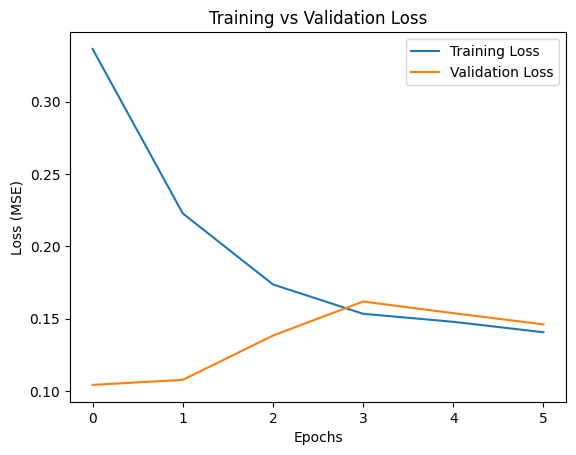

In [8]:
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - loss: 0.1878 - mae: 0.3369 - val_loss: 0.1064 - val_mae: 0.2595 - learning_rate: 1.0000e-05
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 0.1308 - mae: 0.2886 - val_loss: 0.1208 - val_mae: 0.2763 - learning_rate: 1.0000e-05
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.1168 - mae: 0.2719 - val_loss: 0.1246 - val_mae: 0.2811 - learning_rate: 1.0000e-05
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.1128 - mae: 0.2673 - val_loss: 0.1167 - val_mae: 0.2730 - learning_rate: 1.0000e-05
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 0.1105 - mae: 0.2649 - val_loss: 0.1151 - val_mae: 0.2719 - learning_rate: 5.0000e-06


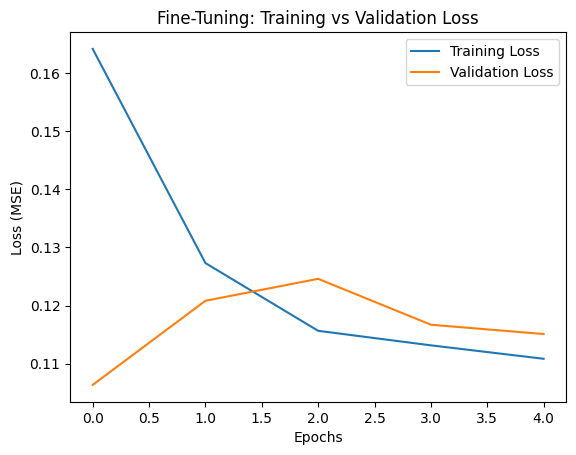

In [9]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# Fine-tune the model
fine_tune_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Plot fine-tuning training progress
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Fine-Tuning: Training vs Validation Loss')
plt.show()

In [3]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Reverse scale for true values
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred)

# Visualize predictions for the first few samples
def visualize_predictions(X, y_true, y_pred, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 5))

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("Input Image")

        # Show true vs predicted values
        plt.subplot(1, 2, 2)
        indices = range(len(y_true[i]))
        plt.bar(indices, y_true[i], alpha=0.6, label='True', color='blue')
        plt.bar(indices, y_pred[i], alpha=0.6, label='Predicted', color='orange')
        plt.xticks(indices, ['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'])
        plt.legend()
        plt.title("True vs Predicted Values")

        plt.show()

visualize_predictions(X_test, y_test_original, y_pred_original)

NameError: name 'model' is not defined

In [2]:
image_path = "Dates/Saqi_005.jpg"
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image) / 255.0

# Predict the nutritional values
nutritional_values = model.predict(np.expand_dims(image, axis=0))
nutritional_values = scaler_y.inverse_transform(nutritional_values)

# Display the nutritional values
print("Predicted Nutritional Values:")
print(f"Calories: {nutritional_values[0][0]:.2f}")
print(f"Proteins: {nutritional_values[0][1]:.2f}")
print(f"Total Fat: {nutritional_values[0][2]:.2f}")
print(f"Glucose: {nutritional_values[0][3]:.2f}")
print(f"Cholesterol: {nutritional_values[0][4]:.2f}")
print(f"Water: {nutritional_values[0][5]:.2f}")
print(f"Energy: {nutritional_values[0][6]:.2f}")



# Plot predicted and actual images side by side
plt.figure(figsize=(12, 5))

# Show image (unflatten and reshape to 64x64)
plt.subplot(1, 2, 1)
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title("Input Image")

# Show true vs predicted values
plt.subplot(1, 2, 2)
indices = range(len(nutritional_values[0]))
plt.bar(indices, nutritional_values[0], alpha=0.6, label='Predicted', color='orange')
plt.xticks(indices, ['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'])
plt.title("Predicted Nutritional Values")

plt.show()



NameError: name 'load_img' is not defined

In [76]:
# Save the model
model.save("003_efficientnet_model.h5")

In [78]:
import numpy as np

# Define accuracy metric for regression
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    # Calculate relative error
    relative_error = np.abs((y_true - y_pred) / y_true)
    # Count predictions within the tolerance range
    accurate_predictions = np.sum(relative_error <= tolerance)
    # Calculate accuracy as a percentage
    accuracy = (accurate_predictions / len(y_true)) * 100
    return accuracy

# Example usage
y_train_pred = model.predict(X_train)  # Predictions on training set
y_test_pred = model.predict(X_test)    # Predictions on testing set

train_accuracy = regression_accuracy(y_train, y_train_pred)
test_accuracy = regression_accuracy(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Train Accuracy: 51.78%
Test Accuracy: 52.40%


/var/folders/pj/k78tnlfd70x2r6r2m3x__yq40000gn/T/ipykernel_21607/2919488463.py:6: RuntimeWarning: divide by zero encountered in divide
  relative_error = np.abs((y_true - y_pred) / y_true)
